In [1]:
# !pip install numpy pandas lightgbm scikit-learn matplotlib seaborn

In [2]:
import csv
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
x_train = pd.read_csv('census-income-training.csv')
x_test = pd.read_csv('census-income-test.csv')

In [4]:
x_train.head(5)

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,year,income_morethan_50K,Id
0,49,Private,43,2,Doctorate degree(PhD EdD),0,Not in universe,Married-civilian spouse present,Education,Executive admin and managerial,...,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,1,1
1,49,Private,45,12,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Professional specialty,...,United-States,United-States,Native- Born in the United States,0,No,1,30,95,0,2
2,49,Private,12,26,High school graduate,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Adm support including clerical,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0,3
3,38,Private,3,34,High school graduate,0,Not in universe,Married-civilian spouse present,Mining,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,0,5
4,46,Not in universe,0,0,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0,6


In [5]:
x_train.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL',
       'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM',
       'AUNTYPE', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FEDTAX',
       'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MIGMTR1',
       'MIGMTR3', 'MIGMTR4', 'MIGSAME', 'NOEMP', 'PARENT', 'PEFNTVTY',
       'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN',
       'WKSWORK', 'year', 'income_morethan_50K', 'Id'],
      dtype='object')

In [6]:
x_train['income_morethan_50K'].unique()

array([1, 0], dtype=int64)

In [7]:
cat_feature_names = ['ACLSWKR', 'AHGA', 'AHSCOL', 'AMARITL', 'AMJIND', 
                     'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 
                     'AUNTYPE', 'AWKSTAT', 'FEDTAX', 'FILESTAT', 'GRINREG', 
                     'GRINST', 'HHDFMX', 'MIGMTR1', 'MIGMTR3', 'MIGMTR4',
                     'MIGSAME', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY',
                     'PRCITSHP', 'VETQVA']

In [8]:
cat_feature_to_int = {}
for col in cat_feature_names:
    cat_feature_to_int[col] = dict(set(zip(x_train[col], x_train[col].rank(method='dense', ascending=False).astype(int))))

In [9]:
for col in cat_feature_names:
    x_train[col] = x_train[col].map(cat_feature_to_int[col])
    x_test[col] = x_test[col].map(cat_feature_to_int[col])

In [10]:
y_train = x_train['income_morethan_50K']
x_train.drop(['income_morethan_50K', 'Id'], axis=1, inplace=True)
x_test_id = x_test['Id']
x_test.drop(['Id'], axis=1, inplace=True)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)

In [12]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_val = lgb.Dataset(x_val, y_val, reference=lgb_train, free_raw_data=False)

In [13]:
num_train, num_feature = x_train.shape
feature_mapping = dict(zip(x_train.columns, [col for col in range(num_feature)]))

In [14]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': "binary_logloss",
    'num_leaves': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    'is_unbalance': False, # Set to true if the metric is F1 score
}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_val,  # eval training data
                categorical_feature=[feature_mapping[col] for col in cat_feature_names],
                callbacks=[lgb.early_stopping(stopping_rounds=2000)],
                )

c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 11045, number of negative: 117531
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 128576, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085903 -> initscore=-2.364724
[LightGBM] [Info] Start training from score -2.364724
Training until validation scores don't improve for 2000 rounds


c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[1537]	valid_0's binary_logloss: 0.146706


In [15]:
pred = gbm.predict(x_val, num_iteration=gbm.best_iteration)

In [16]:
pred_val = (pred > 0.5).astype(int)
print(precision_score(y_val, pred_val))
print(recall_score(y_val, pred_val))
print(f1_score(y_val, pred_val))
print(accuracy_score(y_val, pred_val))
print('baseline', accuracy_score(y_val, np.zeros_like(y_val)))

0.7552795031055901
0.49551752241238795
0.5984251968503937
0.9428851403373696
baseline 0.9141177294043537


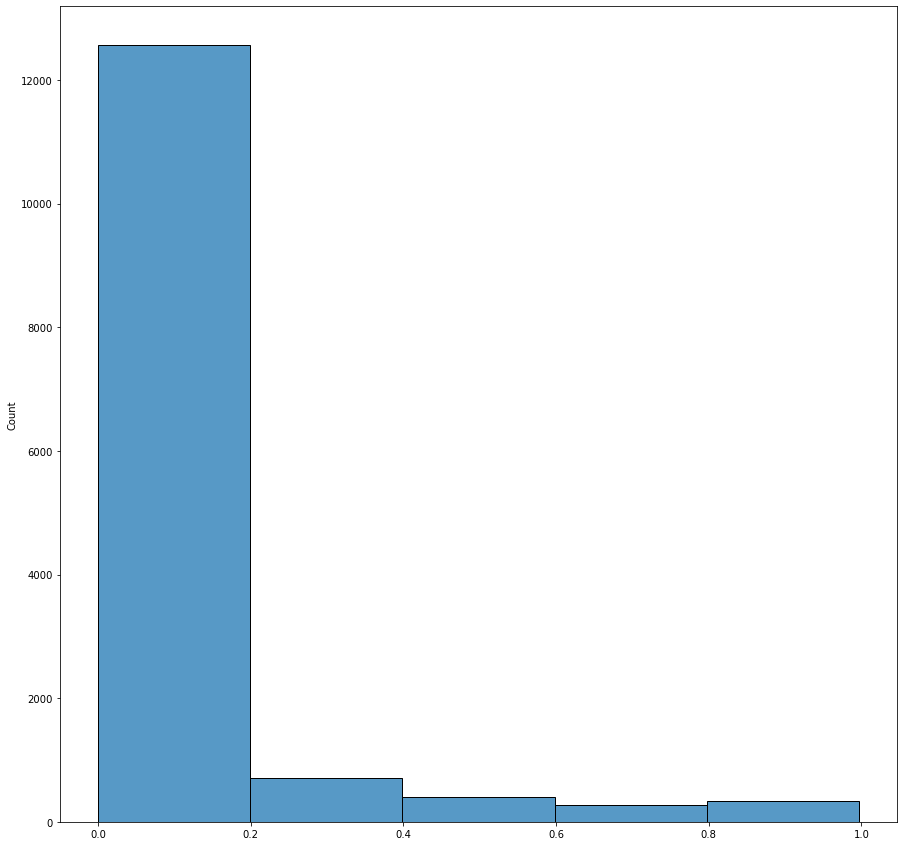

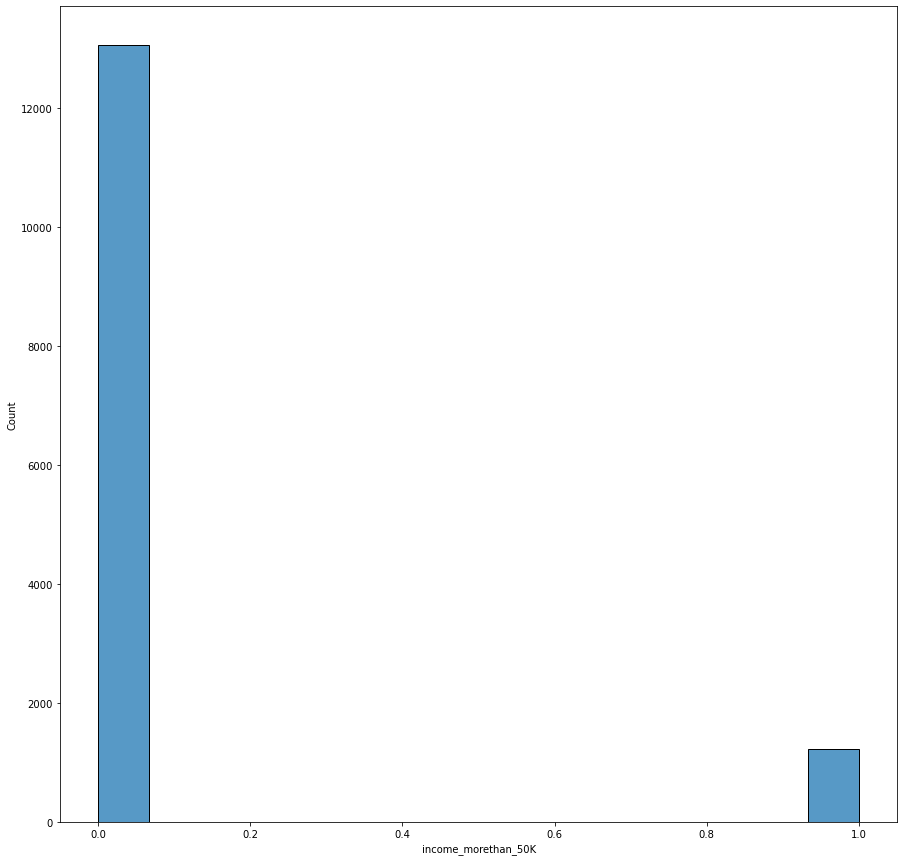

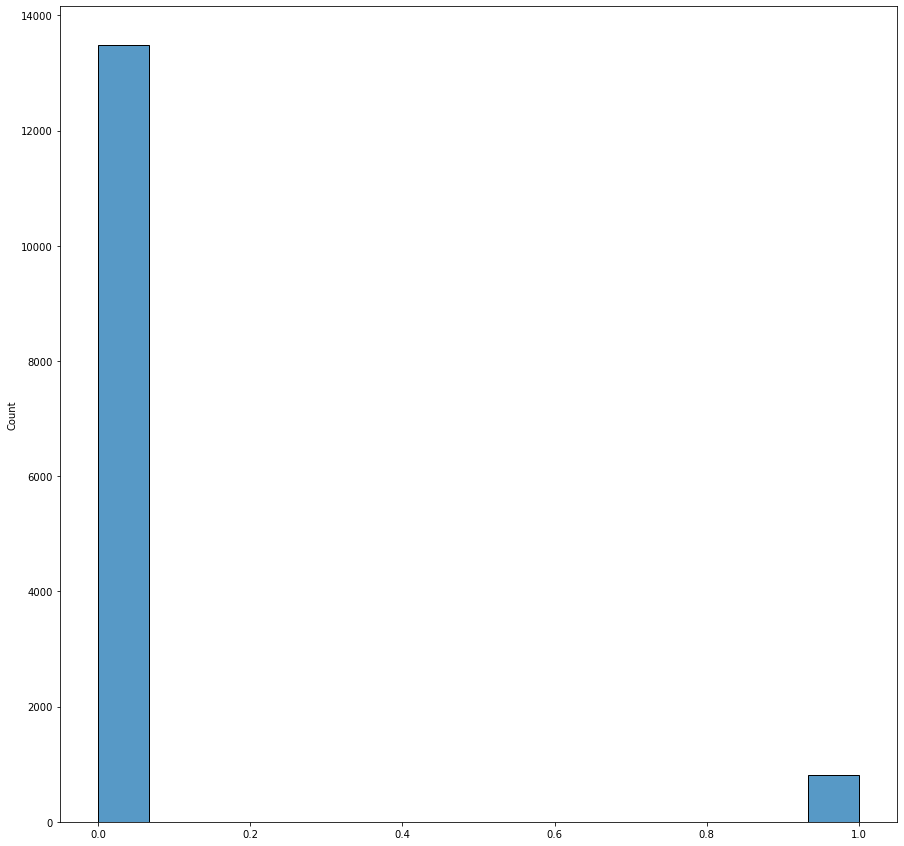

In [17]:
plt.figure(figsize=(15,15))
sns.histplot(pred, bins=5)
plt.show()
plt.figure(figsize=(15,15))
sns.histplot(y_val)
plt.show()
plt.figure(figsize=(15,15))
sns.histplot(pred_val)
plt.show()

In [18]:
pred_test = gbm.predict(x_test, num_iteration=gbm.best_iteration)

In [19]:
y_test = (pred_test > 0.5).astype(int)

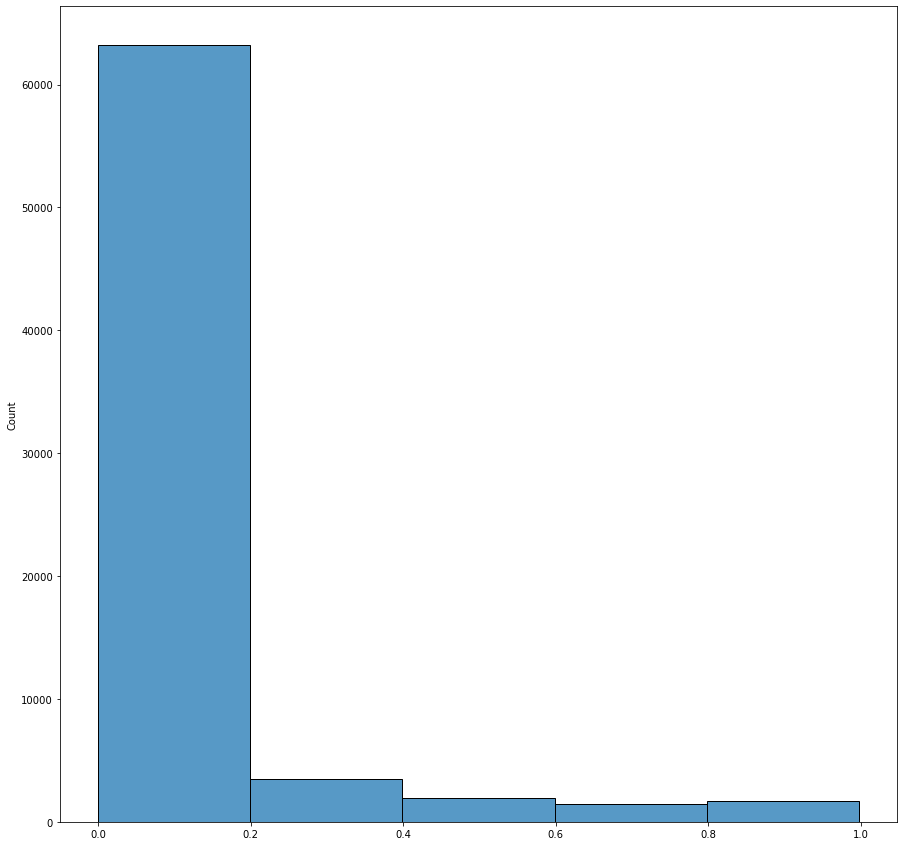

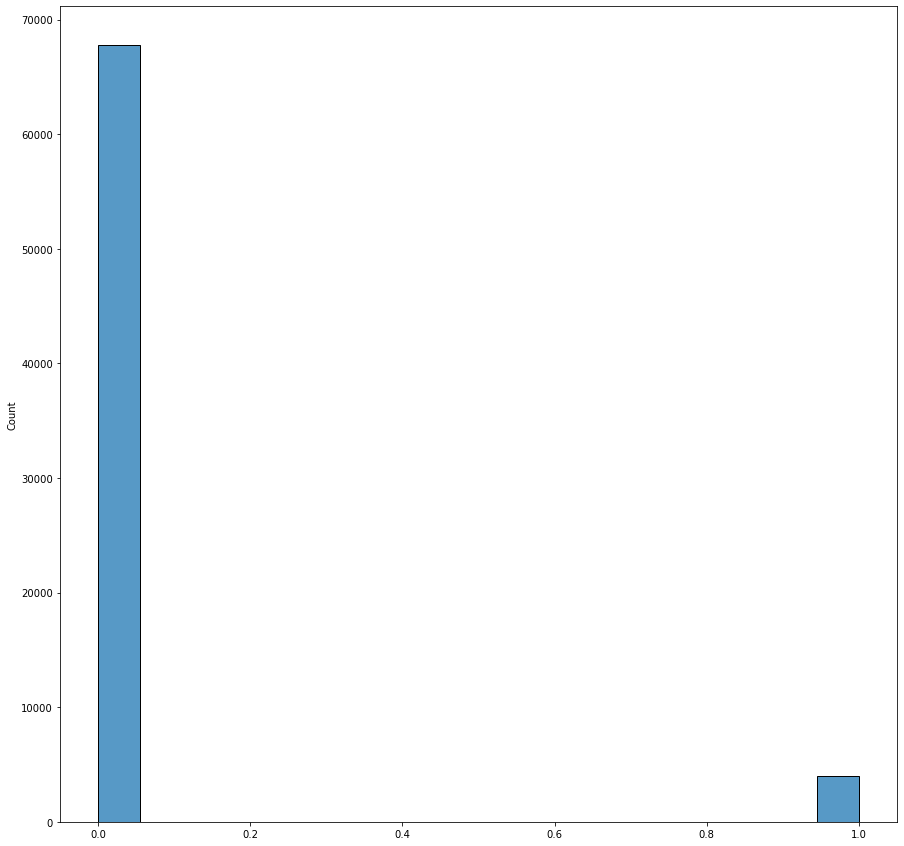

In [20]:
plt.figure(figsize=(15,15))
sns.histplot(pred_test,bins=5)
plt.show()
plt.figure(figsize=(15,15))
sns.histplot(y_test)
plt.show()

In [21]:
with open('pred.csv', 'w', newline='') as csvf:
    writer = csv.writer(csvf)
    writer.writerow(['Id', 'income_morethan_50K'])
    for id, pred in zip(x_test_id, y_test):
        writer.writerow([id, str(pred)])